# Classification using Gaussian distributions

For this weeks assignment, you will implement a *classification* algorithm, which is the other main type of *supervised learning* algorithm (as opposed to *regression*, from last week). Specificially, you will build a *Bayes classifier* using *Gaussian distributions* to estimate the likelihood of continuous variables.

For this we will work with a classic dataset from machine learning; Fisher's Iris dataset. The dataset contains the measurements of *length* and *width* of the *sepals* and *petals* of 150 flowers. 

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" width=250>

Using these 4 attributes (*length* and *width* of both *sepals* and *petals*), the flowers should then be classified as as one of 3 species of Iris flower:

* Iris setosa
* Iris versicolor
* Iris virginica

This dataset is such a classic example that is even included in machine learning libraries. To get started we will install the [scikit-learn](http://scikit-learn.org/stable/index.html) library. For now, we will only use it to load in the dataset, but in later assignments we will use more of its capabilities. Install the library with

    sudo pip3 install scikit-learn
    
and also install the plotting library [seaborn](https://seaborn.pydata.org/) with

    sudo pip3 install seaborn
    
Now the code below should store and show the dataset as the variable `iris`

In [1]:
import math
import matplotlib.pylab as plt
import numpy as np

from sklearn import datasets

iris = datasets.load_iris()
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

## Separate and plot the data [1 pt]

The `iris` variable now contains an object with all sorts of information about the dataset. The 2 most important atributes are *target* and *data* containing respectively the labels and the data points for the 150 flowers. An attribute of this data object can be accessed with **.** as shown below.

Use this to create the matrix $X$ and the vector $R$. Then divide the matrix $X$ into 3 parts, $C_0$, $C_1$ and $C_2$, each containing the data for a different class, as labeled by the vector $R$. *Hint: Some clever [indexing](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#boolean-or-mask-index-arrays) might help here.*

In [2]:
# YOUR SOLUTION HERE
X = iris.data
R = iris.target
C0 = iris.data[iris.target == 0]
C1 = iris.data[iris.target == 1]
C2 = iris.data[iris.target == 2]

Lets plot this data, so we can see what it looks like. We have prepared some code below that plots a so-called scatter matrix. This is a matrix of scatter plots that can be used to easily identify correlations and see the seperability of the dataset. The diagonals of this plot show how the data is distributed for every *single* feature, while the non-diagonals show scatter plots using *two* of the features as the $x$ and $y$ axis, with all the different possible configurations shown in the matrix.

The different colors here correspond to the different classes of Iris, which is the same separation you just made, dividing the data points into $C_0$, $C_1$ and $C_2$.

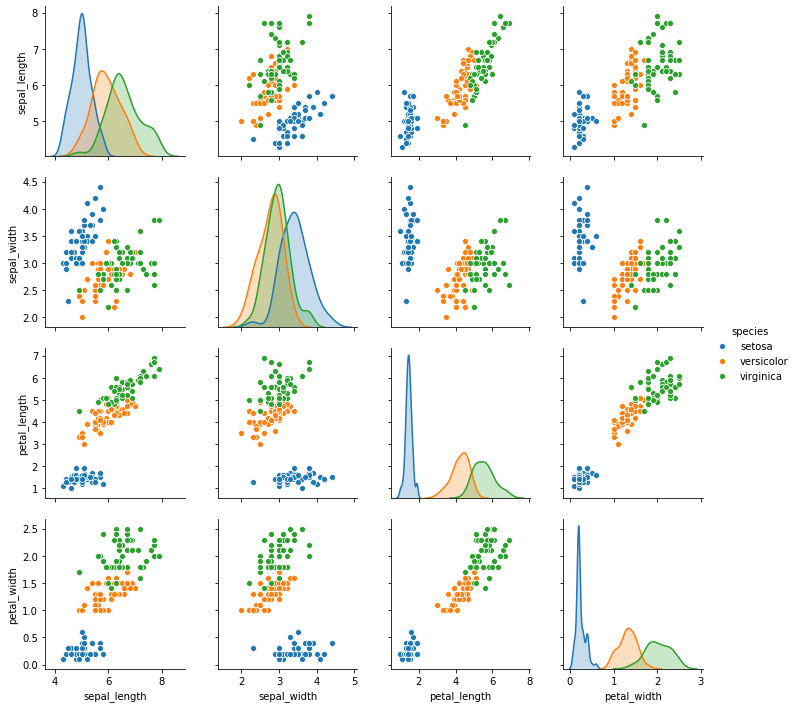

In [3]:
import seaborn as sns

df_iris = sns.load_dataset('iris')
sns.pairplot(df_iris, hue='species')
plt.show()

Looking at these plots, it should be quite clear that the Setosa species is more easily separated than Versicolor and Virginica. Also, it seems that quite a few of the variable combinations are correlated with each other.

## Inspect and estimate the correlations [1pt]

One measure of how variables are correlated is the covariance. The covariance between two jointly distributed real-valued random variables $X$ and $Y$  is defined as the expected product of their deviations from their individual expected values: 

\begin{align}
\operatorname{cov}(X, Y)
&= \operatorname{E}\left[\left(X - \operatorname{E}\left[X\right]\right) \left(Y - \operatorname{E}\left[Y\right]\right)\right] \\
&= \operatorname{E}\left[X Y - X \operatorname{E}\left[Y\right] - \operatorname{E}\left[X\right] Y + \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]\right] \\
&= \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] + \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] \\
&= \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right],
\end{align}

When covariance is positive, this means that the variables are positively correlated: i.e. when one variable increases in value, it is probable that the other variable also increases. When covariance is negative, this means that the variables are negatively correlated: i.e. when one variable increases in value, it is probable that the other variable decreases. When covariance is near zero, there is no correlation between the variables.

In the cell below we have provided you with a small bit of code that should help you to fit a first Gaussian distribution to the Versicolor part of the data. The code generates some samples from a 2 dimensional Gaussian distribution, using a *mean vector* and a *covariance matrix* and plots those together with the data. The mean vector and both the standard deviations have already been provided, but to complete the covariance matrix, the covariance between the two features should also be set.

Together, this is enough to start generating samples, and the more the different distributions overlap, the better the fit of the generated distribution. Manually change the variable `covar` such that the distribution of the generated samples overlaps as much as possible with the real data. 

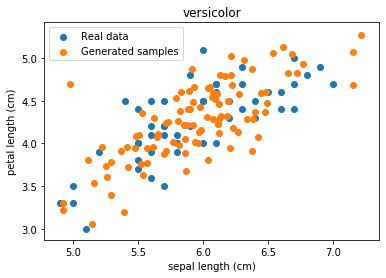

[[0.25 0.18]
 [0.18 0.22]]


In [4]:
target_class = 1
x_feature = 0
y_feature = 2

std_x = 0.25
std_y = 0.22

covar = 0.18 # Change me

cov = np.array([[std_x, covar], [covar, std_y]])

mean = [np.mean(C1[:, x_feature]), np.mean(C1[:, y_feature])]

samples = np.random.multivariate_normal(mean, cov, size=100)

plt.scatter(C1[:, x_feature], C1[:, y_feature], label='Real data')
plt.scatter(*zip(*samples), label='Generated samples')
plt.title(iris.target_names[target_class])
plt.xlabel(iris.feature_names[x_feature])
plt.ylabel(iris.feature_names[y_feature])
plt.legend()
plt.show()

print(cov)

**How do the values of `std_x` and `std_y` affect the shape of the resulting distribution?**

The greater `std_x` is, the more spread out the distribution is in the direction of the x axis;
the greater `std_y` is, the more spread out the distribution is in the direction of the y axis;

**How are the sepal length and petal length correlated for the Versicolor class?**

When I set `cover` to 0.18, the generated samples overlaps a lot with the real data. So the sepal length and petal length are positively correlated.

## Validation sets [1 pt]

Now that we have an idea what our dataset looks like, our goal is to create a model that will predict the class (in this case iris species) based on the other variables. In order to evaluate how well the model fits, we will also need a validation set where we can test some of our predictions. For this we will again split the data into a training and a validation set. Fill in the function below, you can use your function from last week as inspiration. Don't forget to randomize your data before splitting.

Now use this function on the data from each of the 3 classes, using a ratio of $0.7$ for each. This should result in 3 different training sets and 3 different validation sets. Be sure to name them all differently, so you can still use them all later in the assignment.

In [5]:
def validation_split(data, ratio):
    # YOUR SOLUTION HERE
    np.random.shuffle(data)
    n = int(ratio*len(data))
    training_set = data[:n, :]
    validation_set = data[n:, :]
    return training_set, validation_set
# YOUR SOLUTION HERE
train0, val0 = validation_split(C0, 0.7)
train1, val1 = validation_split(C1, 0.7)
train2, val2 = validation_split(C2, 0.7)

## Univariate model [1 pt]

Looking at the scatter matrix of the data from the previous section, you might conclude that separating the different classes would be a lot easier based on the petal data (3rd and 4th variable) than on the sepal data (1st and 2nd variable), as it easier to distinguish the different clusters in that plot. In fact, for now we will only focus on 1 variable, the petal length (3rd variable), as it looks like it might be useful just on its own and this will simplify the model a lot.

Using the training data from each of 3 classes, compute the mean and standard deviation for the *petal length* attribute for each class. The Maximum Likelihood Estimators for these are given by

(4.8a) $$m = \frac{\sum_{t=1}^Nx^t}{N}$$

(4.8b) $$s = \sqrt{\frac{\sum_{t=1}^N(x^t - m)^2}{N}}$$

You can also use the built-in *Numpy* functions for [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [standard deviation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html). Print the results for each class and make sure they make sense in comparison to the plot.

In [6]:
# YOUR SOLUTION HERE
m0 = np.mean(C0[:,2])
s0 = np.std(C0[:,2])
m1 = np.mean(C1[:,2])
s1 = np.std(C1[:,2])
m2 = np.mean(C2[:,2])
s2 = np.std(C2[:,2])
print('The petal length for Setosa: \tmean: ' + str(m0)  + '\tstandard deviation: ' + str(s0))
print('The petal length for Versicolour: \tmean: ' + str(m1) + '\t\t\t\tstandard deviation: ' + str(s1))
print('The petal length for Virginica: \tmean: ' + str(m2) + '\tstandard deviation: ' + str(s2))

The petal length for Setosa: 	mean: 1.462	standard deviation: 0.17191858538273283
The petal length for Versicolour: 	mean: 4.26				standard deviation: 0.4651881339845203
The petal length for Virginica: 	mean: 5.5520000000000005	standard deviation: 0.546347874526844


## Probability density function [2 pts]

The probability density function for a Gaussian distribution is defined as

(4.7) $$p(x|\mu, \sigma)=\frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

where $X$ is Gaussian (normal) distributed with mean $\mu$ and variance $\sigma^2$, denoted as $\mathcal{N}(\mu, 
\sigma^2$).

That means that if we have estimates for $\mu$ and $\sigma$, we can compute the probability density for a specific value $x$. Implement this in the function below.

We already made estimates for $\mu$ and $\sigma$ for the *petal length* for each of the 3 classes, so we can now define PDFs for each separate class. Plot the 3 functions using [linspace](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linspace.html) for a range of x-values (like in last weeks assignment) and apply the PDF functions to obtain the y-values. Use the previous plots to estimate a sensible range for *linspace* and make sure that the plotted densities correspond with your expectations.

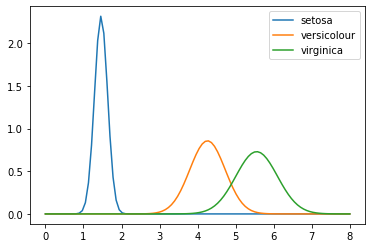

In [7]:
def PDF(x, m, s):
    # YOUR SOLUTION HERE
    return np.exp(-(x-m)**2/(2*s**2))/(np.sqrt(2*np.pi)*s)
# YOUR SOLUTION HERE
x = np.linspace(0, 8, 100)
y0 = PDF(x, m0, s0)
y1 = PDF(x, m1, s1)
y2 = PDF(x, m2, s2)
plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['setosa', 'versicolour', 'virginica'])
plt.show()

## Posterior probabilities [2 pts]

The plot above shows the probability densities for a value $x$, provided that you know the parameters for a specific class $C_i$, i.e. $p(x | \mu_i, \sigma_i)$. Because the mean and standard deviation are suffient statistics for normally distributed data, this is equivalent to the probability density given that specific class $p(x | C_i)$. However, what would be useful for classification, is the posterior probabilities of the classes given the data, i.e. $P(C_i | x)$. We can use Bayes' rule for this

(3.5) $$P(C_i | x) =  \frac{p(x | C_i) P(C_i)}{p(x)} = \frac{p(x | C_i) P(C_i)}{\sum_{k=1}^K p(x | C_k) P(C_k)}$$

Because here we have no prior knowledge of the distribution of the different classes, we can just assume all prior class probabilities $P(C_i)$ to be equal. For our 3 class problem, that would mean a probability of $\frac{1}{3}$ for each class, but we can also just factor the common prior out of the equation and simplify to

$$P(C_i | x) = \frac{p(x | C_i)}{\sum_{k=1}^K p(x | C_k)}$$

In order to make the code a little easier to write, make a vector $m$ with all values of $m_i$ and vector $s$ with all values of $s_i$, where $m_i$ and $s_i$ are the estimates for the class $C_i$. You can then just use those 2 vectors and a parameter $i$ to indicating which class you want to compute the posterior for. Write the function for the `posteriors`. It should return the posterior for each of the three classes as a list. Plot the posterior probabilities for all 3 classes. Does the plot of these 3 posteriors make sense based on the data?

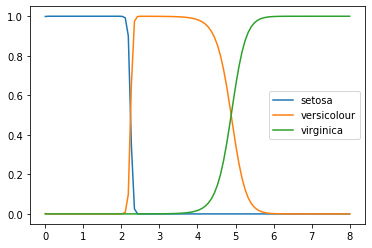

In [8]:
def posteriors(x, m, s):
    # YOUR SOLUTION HERE
    return [PDF(x, m[i], s[i]) for i in range(len(m))]
# YOUR SOLUTION HERE
x = np.linspace(0, 8, 100)
m = [m0, m1, m2]
s = [s0, s1, s2]
y = np.array([posteriors(xi, m, s)/np.sum(posteriors(xi, m, s)) for xi in x])
#y = posteriors(x, m, s)
for i in range(y.shape[1]):
    plt.plot(x, y[:, i])
plt.legend(['setosa', 'versicolour', 'virginica'])
plt.show()

## Bayes Classifier [2 pts]

Now that we can compute the posteriors for every class, constructing a classifier is easy. The Bayes classifier is defined as

(3.6) $$choose\ C_i\ if\ P (C_i |x) = max_k\ P(C_k |x)$$

Write the code for the `classify` function. It should classify a single data point $x$ as one of the 3 classes, returning $0$, $1$ or $2$ based on the which class the flower is most likely to belong to. The other arguments of the function should therefore be the vector of mean estimates $m$ and the vector of standard deviation estimates $s$.

Next complete the `validate` function below. It should take a validation set, the expected class for all data points in that set and the vectors $m$ and $s$ with which to make the classifications. Based on this, it should return the percentage of elements in the validation set that were classified correctly.

Remember that the mean and standand deviation estimates we have computed are only based on the *petal length* variable, while a data point in the validation set consists of a complete row, i.e. all 4 variables describing the dimensions of a flower instance. So, for now, you will only need to use the *petal length* variable from each data point to attempt to classify it.

Apply the `validate` function to all 3 validation sets and report the percentage correct for each class. Also include the average correct percentage for all 3 classes.

In [9]:
def classify(x, m, s):
    # YOUR SOLUTION HERE
    return np.argmax(posteriors(x, m, s), axis = 0)
def validate(val, expected, m, s):
    # YOUR SOLUTION HERE
    pred = classify(val[:, 2], m, s)
    return len([i for i in pred if i == expected]) / len(pred)
# YOUR SOLUTION HERE
print('Correct percentage for class 0: ' + str(validate(val0, 0, m, s)))
print('Correct percentage for class 1: ' + str(validate(val1, 1, m, s)))
print('Correct percentage for class 2: ' + str(validate(val2, 2, m, s)))
print('Average correct percentage: ' + str(np.mean([validate(val0, 0, m, s), validate(val1, 1, m, s), validate(val2, 2, m, s)])))

Correct percentage for class 0: 1.0
Correct percentage for class 1: 0.9333333333333333
Correct percentage for class 2: 0.9333333333333333
Average correct percentage: 0.9555555555555556


# Multivariate distributions

You should already get pretty good results using just the *petal length* variable (depending on the splits that were made for the validation sets, the exact percentage might vary a little), but maybe we can do better still. Looking at the original plots of the data, you might conclude that there could be more information for the classification in the other variables, so a multi-variate approach would make sense. This means we will need a multi-variate version of the probability density function for normal distributions, which is defined as

(5.9) $$p(\boldsymbol{x}|\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{\frac{d}{2}}|\boldsymbol{\Sigma}|^{\frac{1}{2}}} e^{-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{x} - \boldsymbol{\mu})}$$

where $\boldsymbol{x}$ is a $d$-dimensional vector drawn from the normal distribution $\mathcal{N}_d(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$.

If we used all 4 variables in the dataset to compute the vector of means and the covariance matrix for each class, then we could use the above equation to compute the probability densities for each class, with those the posteriors for each class and finally use the same Bayes classifier to select the most probable class for a data point. However if the number of variables is large, then the number parameters for the covariance matrix (sized $d \times d$) can become too large to properly fit to the amount of data we have. It is therefore common to make some simplifying assumptions, to decrease the complexity of the model. One well know variant is *Naive Bayes*, where the assumption is that all variables are independent. This means the model only uses the variance for each variable and no covariances are included, which corresponds to a covariance matrix with only entries on the diagonal.

## Naive bivariate distributions [4 pts]

We will start with a bi-variate (i.e. 2 variables) distribution, as this will be easier to plot, visualize, and thus reason about. Looking at the original 2 plots of the data, the second plot using the *petal lenght* and *petal width* seems to result in nice clusters, so will use those 2 variables.  We will use the *Naive Bayes* model for our bivariate data. Even if computing the covariance might not be problematic in this case, it will still be useful to see the effect of such a simplifying assumping.

This assumption of independence might be *naive* using real world data, you might even expect *length* and *width* of flower petals to be strongly correlated, but it turns out *Naive Bayes* can still make an effective classifier. The assumption of independence also simplifies the equation a lot: Instead of writing out the full version using the covariance matrices, we can write a multi-variate distribution as a product of one-dimensional distributions for each variable. So for our 2 variable case:

$$p(\boldsymbol{x}| C_i) = p(x_1 | C_i) p(x_2 | C_i)$$

Where $p(x_1 | C_i)$ is the old univariate distribution using the $\mu_1$ and $\sigma_1$ parameters of the first variable for class $C_i$ and $p(x_2 | C_i)$ is the same equation using the $\mu_2$ and $\sigma_2$ parameters of the second variable for class $C_i$.

Start by writing this *naive* version of the probability density function for the bivariate case. You will also have to compute the 3 means (for each of the 3 classes) and 3 standard deviations for the additional *petal width* variable. You should already have the code to compute these for the *petal length* variable from the univariate distributions. 

Now we will plot the density for each class to see what they look like. These plots will be a 3-dimensional; 2 dimensions for the values of *petal length* and *petal width*, and 1 dimension for the probability density belonging to that combination of variables. There are several ways to make 3d plots in *matplotlib*; we will use contour plots, as that is also what is used most in the book (see figure 5.3, 5.4, 5.5 and 5.6). Start with a simple plot of the point values of the 2 variables using a different color for each class (like at the start of the assignment) and overlay the 3 contours on top of them.

Construct a mesh of X and Y values using [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) for each dimension and combining them with [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html). Then compute the Z values for a probability density function of 1 class and use the [contour](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contour) function to plot those Z values. Repeat this for the other 2 classes and show the final plot. You can also look at some demo uses of contour [here](http://matplotlib.org/examples/pylab_examples/contour_demo.html).

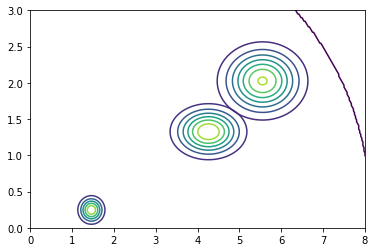

In [10]:
def PDF_naive(x1, x2, m1, m2, s1, s2):
    # YOUR SOLUTION HERE
    return PDF(x1, m1, s1)*PDF(x2, m2, s2) 
# YOUR SOLUTION HERE
x = np.linspace(0, 8, 320)
y = np.linspace(0, 3, 120)
X, Y = np.meshgrid(x, y)
Z0 = PDF_naive(X, Y, np.mean(C0[:, 2]), np.mean(C0[:, 3]), np.std(C0[:, 2]), np.std(C0[:, 3]))
Z1 = PDF_naive(X, Y, np.mean(C1[:, 2]), np.mean(C1[:, 3]), np.std(C1[:, 2]), np.std(C1[:, 3]))
Z2 = PDF_naive(X, Y, np.mean(C2[:, 2]), np.mean(C2[:, 3]), np.std(C2[:, 2]), np.std(C2[:, 3]))
plt.contour(X, Y, Z0)
plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)
plt.show()

## Naive classifier [4 pts]

Now that you have the naive bivariate version of the `PDF` fuctions, constructing the *Naive Bayes* classifier will be straightforward. Simply adapt your previous `posteriors`, `classify` and `validate` functions to work with your `PDF_naive` function.

Show the validation results for each of the 3 classes and the average over all 3 classes.

In [11]:
def posteriors_naive(x1, x2, m1, m2, s1, s2):
    # YOUR SOLUTION HERE
    return [PDF_naive(x1, x2, m1[i], m2[i], s1[i], s2[i]) for i in range(len(m1))]
def classify_naive(x1, x2, m1, m2, s1, s2):
    # YOUR SOLUTION HERE
    return np.argmax(posteriors_naive(x1, x2, m1, m2, s1, s2), axis = 0)
def validate_naive(val, expected, m1, m2, s1, s2):
    # YOUR SOLUTION HERE
    pred = classify_naive(val[:, 2], val[:, 3], m1, m2, s1, s2)
    return len([i for i in pred if i == expected]) / len(pred)
# YOUR SOLUTION HERE
m1 = [np.mean(C0[:, 2]), np.mean(C1[:, 2]), np.mean(C2[:, 2])]
m2 = [np.mean(C0[:, 3]), np.mean(C1[:, 3]), np.mean(C2[:, 3])]
s1 = [np.std(C0[:, 2]), np.std(C1[:, 2]), np.std(C2[:, 2])]
s2 = [np.std(C0[:, 3]), np.std(C1[:, 3]), np.std(C2[:, 3])]
print('Correct percentage for class 0: ' + str(validate_naive(val0, 0, m1, m2, s1, s2)))
print('Correct percentage for class 1: ' + str(validate_naive(val1, 1, m1, m2, s1, s2)))
print('Correct percentage for class 2: ' + str(validate_naive(val2, 2, m1, m2, s1, s2)))
print('Average correct percentage: ' + str(np.mean([validate_naive(val0, 0, m1, m2, s1, s2), validate_naive(val1, 1, m1, m2, s1, s2), validate_naive(val2, 2, m1, m2, s1, s2)])))

Correct percentage for class 0: 1.0
Correct percentage for class 1: 1.0
Correct percentage for class 2: 0.9333333333333333
Average correct percentage: 0.9777777777777779


## Decision boundaries [1 pt]

In *Alpaydin* the posterior equations are simplified as much as possible into a discriminant function, while still retaining the property

$$g_i(x) > g_j(x) \iff P(x|C_i) > P(x|C_j)$$

This can simplify the computation, or help gain insight in the actual distinguishing elements of the particular model. With some algebra, they can also be written into equations for the decision boundaries (the line where $g_i(x) = g_j(x)$). As we have a computer at our disposal, we won't worry too much about how many computations are needed and just let the machine do the work. If you make a contour plot of the complete posterior, these contours should also meet at the decision boundary, while being a lot less work to program.

For the previous cell you already wrote the `posteriors_naive` function, so all that is left is to make contour plots just like for the `PDF_naive` function. Show the points for the 3 classes again and overlay the 3 posterior contours on top. Do the decision regions look like you would expect?

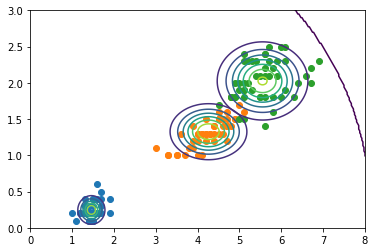

In [12]:
# YOUR SOLUTION HERE
plt.scatter(C0[:, 2], C0[:, 3])
plt.scatter(C1[:, 2], C1[:, 3])
plt.scatter(C2[:, 2], C2[:, 3])
x = np.linspace(0, 8, 320)
y = np.linspace(0, 3, 120)
X, Y = np.meshgrid(x, y)
plt.contour(X, Y, posteriors_naive(X, Y, m1, m2, s1, s2)[0])
plt.contour(X, Y, posteriors_naive(X, Y, m1, m2, s1, s2)[1])
plt.contour(X, Y, posteriors_naive(X, Y, m1, m2, s1, s2)[2])
plt.show()

## Full bivariate distribution [3 pts]

Finally, we will compare this naive bivariate distribution with a full bivariate distribution, using the complete covariance matrix. In order to skip programming out the complete equations for this, you may use a built-in function, namely [multivariate normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) from the *SciPy* stats module. With this we can create a distribution based on a mean vector and a covariance matrix. This distribution can then be used to compute the probability density for a vector of x values, like so:

    distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
    prob_density = distribution.pdf(x_vector)

The mean vector and covariance matrix for a class can be computed using the *Numpy* functions [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [covariance](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html).

Create 3 distributions, one for each class, using the functions linked above. Write the `PDF_full` function, which takes a `distr` argument that should correspond to one distribution for a class. Use that distribution to compute the probability density of the pair `x1`, `x2`.

Again plot the points for the 3 classes, using different colors for each class and overlay the contours of the probability densities for each of the 3 classes using a meshgrid. This should be the same as your contour plot for the naive bivariate distribution, only now using the full bivariate distribution to compute the densities. 

**What is the difference between these 2 plots? Why?**

The plot of Naive bivariate distributions is symmetric with respect to the x-axis and y-axis because of the assumption of independence; The plot of bivariate distribution is not because of the existence of the covariance.

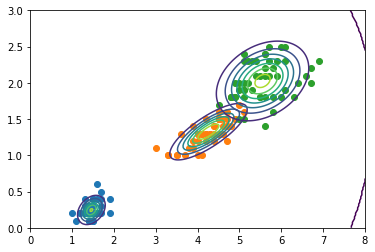

In [13]:
from scipy.stats import multivariate_normal

def PDF_full(x1, x2, distr):
    # YOUR SOLUTION HERE
    pos = np.dstack((x1, x2))
    return distr.pdf(pos)
# YOUR SOLUTION HERE
plt.scatter(C0[:, 2], C0[:, 3])
plt.scatter(C1[:, 2], C1[:, 3])
plt.scatter(C2[:, 2], C2[:, 3])
x = np.linspace(0, 8, 320)
y = np.linspace(0, 3, 120)
X, Y = np.meshgrid(x, y)
distr0 = multivariate_normal([np.mean(C0[:, 2]), np.mean(C0[:, 3])], np.cov(C0[:, 2], C0[:, 3]))
distr1 = multivariate_normal([np.mean(C1[:, 2]), np.mean(C1[:, 3])], np.cov(C1[:, 2], C1[:, 3]))
distr2 = multivariate_normal([np.mean(C2[:, 2]), np.mean(C2[:, 3])], np.cov(C2[:, 2], C2[:, 3]))
Z0 = PDF_full(X, Y, distr0)
Z1 = PDF_full(X, Y, distr1)
Z2 = PDF_full(X, Y, distr2)
plt.contour(X, Y, Z0)
plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)
plt.show()

## Full bivariate classifier [3 pts]

Adapt your `posteriors`, `classify` and `validate` functions to work your `PDF_full` function. Each function should take a `distrs` argument, which should be a list containing the 3 `multivariate_normal` distributions for the 3 classes.

Show the validation results for each of the 3 classes and the average over all 3 classes.

In [14]:
def posteriors_full(x1, x2, distrs):
    # YOUR SOLUTION HERE
    li = []
    for i in range(len(distrs)):
        li.append(PDF_full(x1, x2, distrs[i]))
    li = li / np.sum(li)
    return li
def classify_full(x1, x2, distrs):
    # YOUR SOLUTION HERE
    return np.argmax(posteriors_full(x1, x2, distrs), axis = 0)
def validate_full(val, expected, distrs):
    # YOUR SOLUTION HERE
    pred = classify_full(val[:, 2], val[:, 3], distrs)
    return len([i for i in pred if i == expected]) / len(pred)
# YOUR SOLUTION HERE
distrs = [distr0, distr1, distr2]
print('Correct percentage for class 0: ' + str(validate_full(val0, 0, distrs)))
print('Correct percentage for class 1: ' + str(validate_full(val1, 1, distrs)))
print('Correct percentage for class 2: ' + str(validate_full(val2, 2, distrs)))
print('Average correct percentage: ' + str(np.mean([validate_full(val0, 0, distrs), validate_full(val1, 1, distrs), validate_full(val2, 2, distrs)])))

Correct percentage for class 0: 1.0
Correct percentage for class 1: 1.0
Correct percentage for class 2: 0.9333333333333333
Average correct percentage: 0.9777777777777779
